## Data Plots

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

The runs analyzed are:  [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]
The reference run is:  [72]


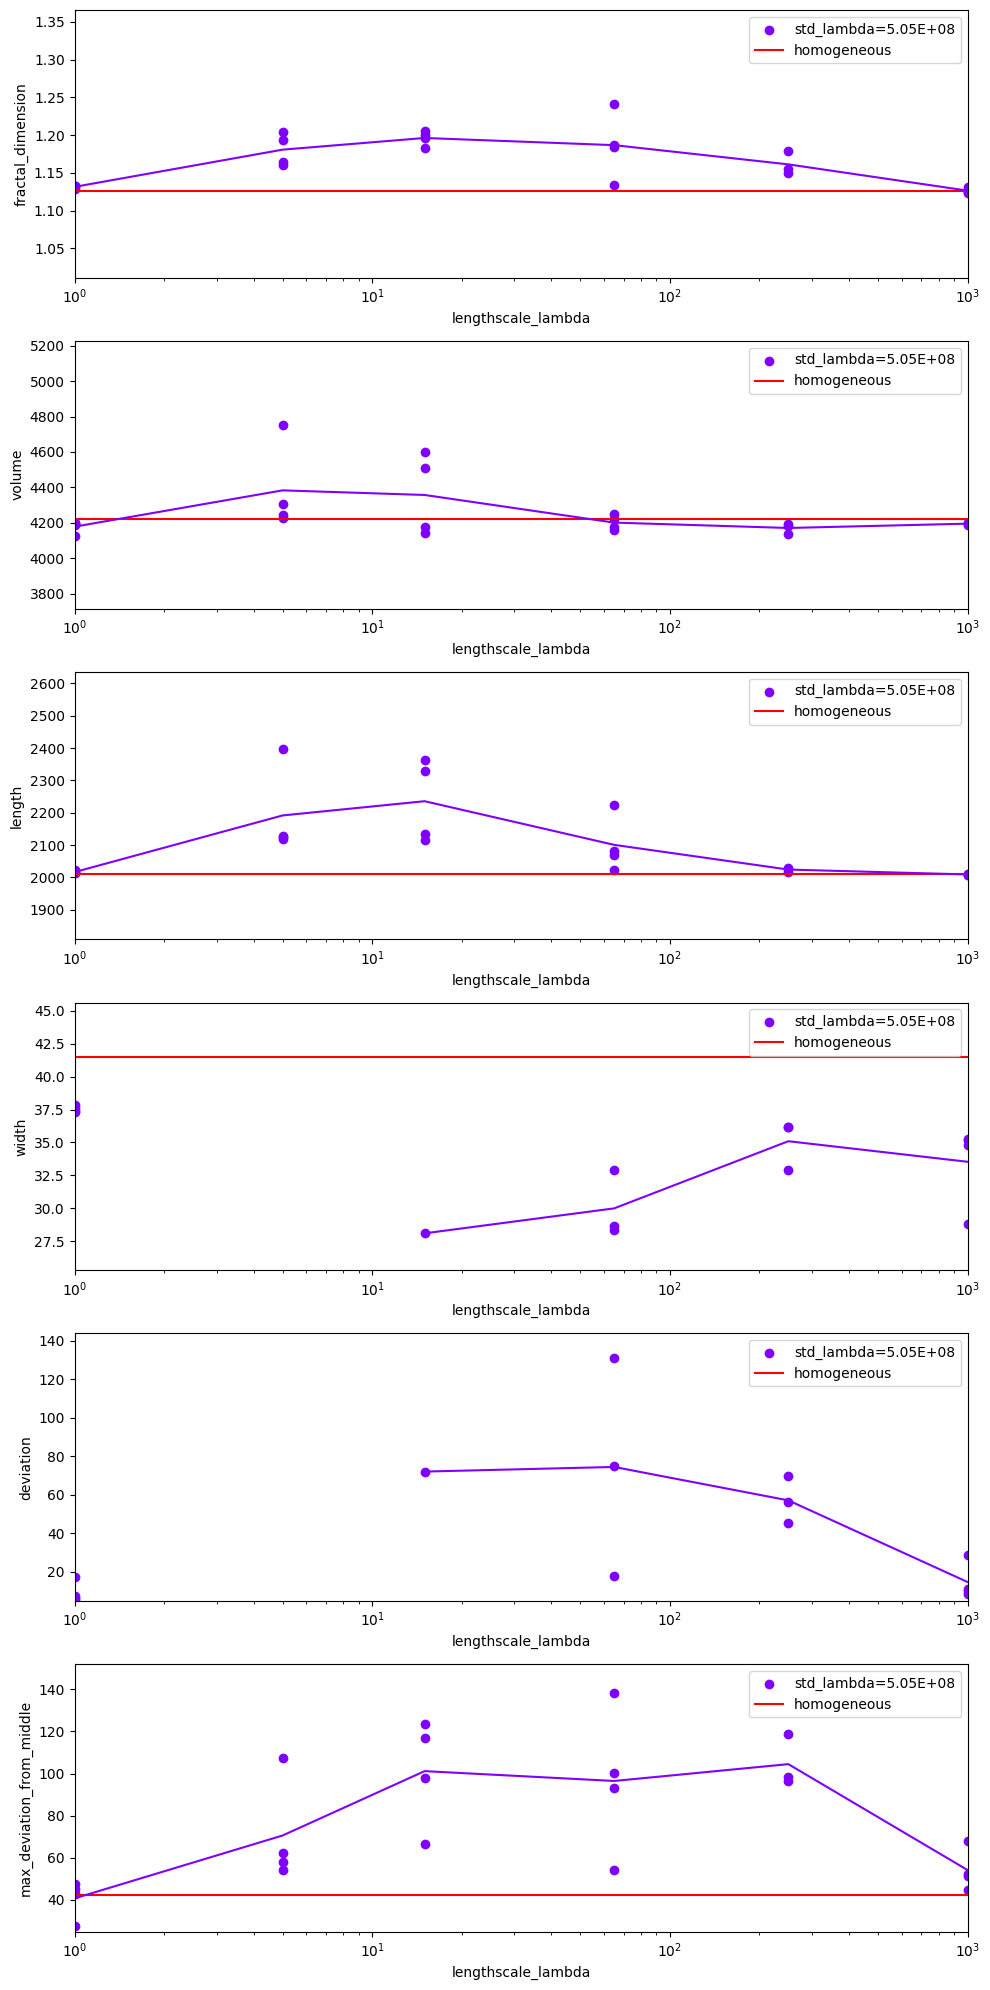

[   1.    5.   15.   50.   65.  250. 1000.]


In [7]:
import pandas as pd
import src.simulation.plotting as plotting
import src.simulation.analysis as analysis
import src.simulation.postprocessing as postprocessing

do_postprocessing = False
if do_postprocessing:
    df = pd.read_csv("results/simulation_results.csv", index_col=0)
    simulations = df.to_dict(orient="records")
    postprocessing_results = postprocessing.postprocess(simulations)
    pd.DataFrame(postprocessing_results).to_csv("results/postprocessing_results.csv")

df = pd.read_csv("results/postprocessing_results.csv", index_col=0)
# Limit to the set, where std_lambda=5.05E8 or homogeneous=True
df = df[(df["std_lambda"] == 5.05e8) | (df["homogeneous"] == True)]
print("The runs analyzed are: ", df["run"].unique())
print("The reference run is: ", df[df["homogeneous"] == True]["run"].unique())
# sim_res = df.to_dict(orient="records")
# postprocessing_results = postprocessing.postprocess(sim_res)
# pd.DataFrame(postprocessing_results).to_csv("results/postprocessing_results.csv")
postprocessing_results = df.to_dict(orient="records")
analysis_results = analysis.analyze(postprocessing_results)
df = pd.DataFrame(analysis_results)
df.to_csv("results/analysis_results.csv")
plotting.plot(df, create_subplots=True)

length_scales_lambda = df["lengthscale_lambda"].unique()
# sort the list
length_scales_lambda.sort()
print(length_scales_lambda)

In [8]:
# TODO: Plot the fractures and check the results for different iso_values

## Plot Isolines

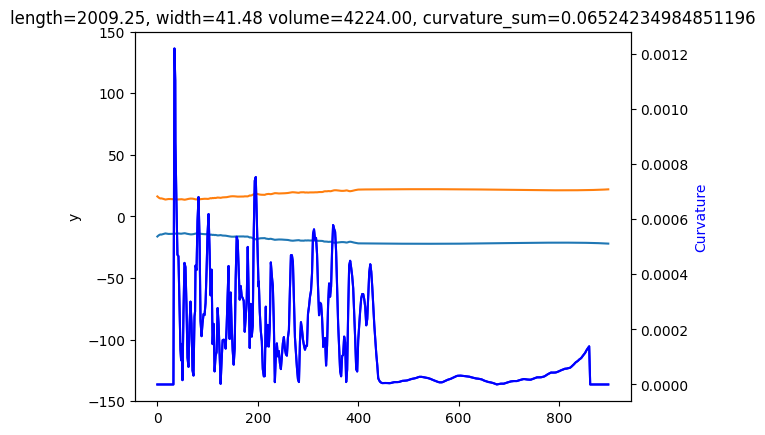

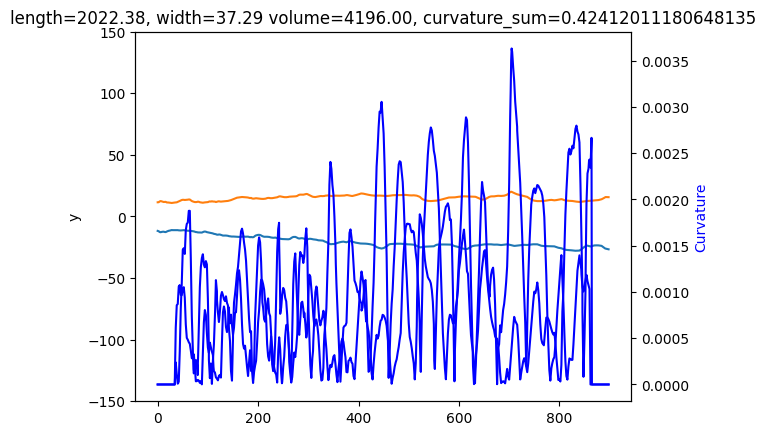

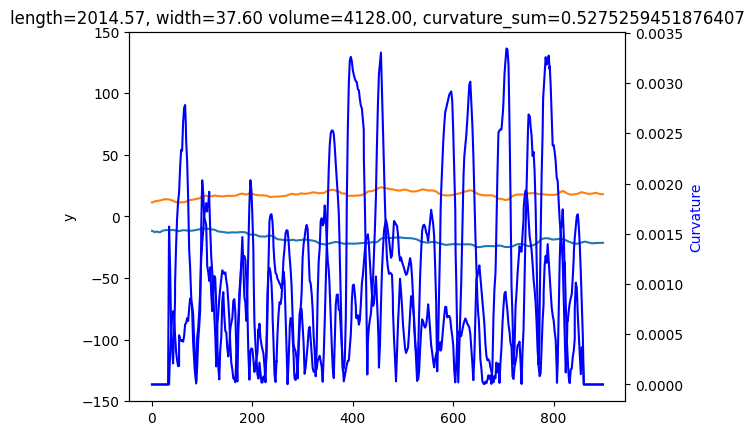

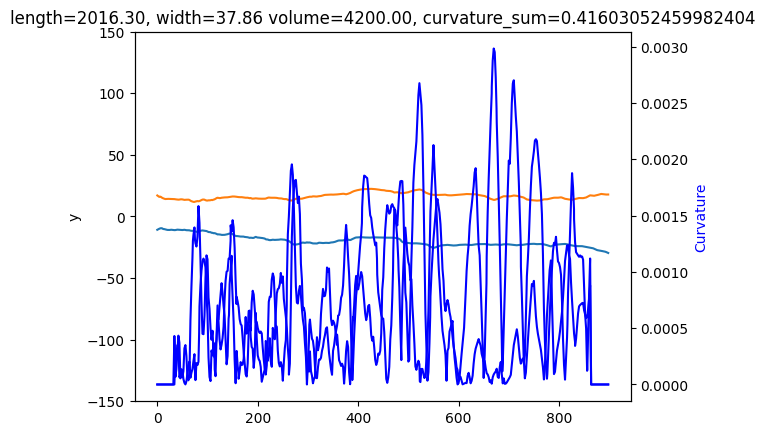

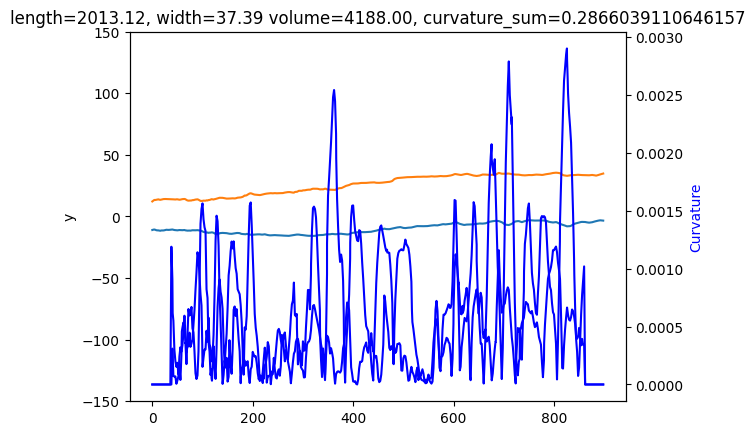

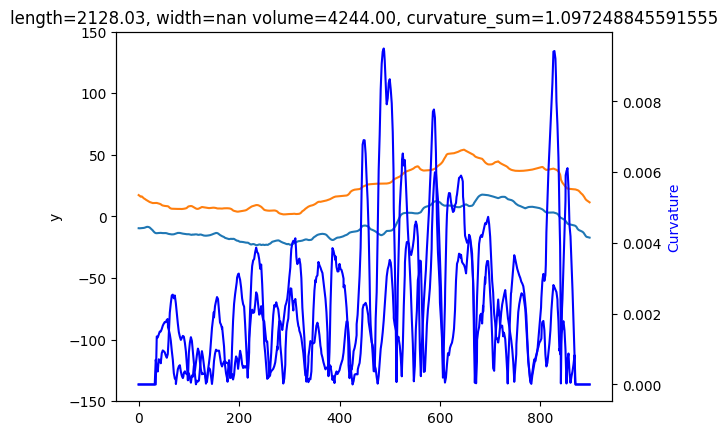

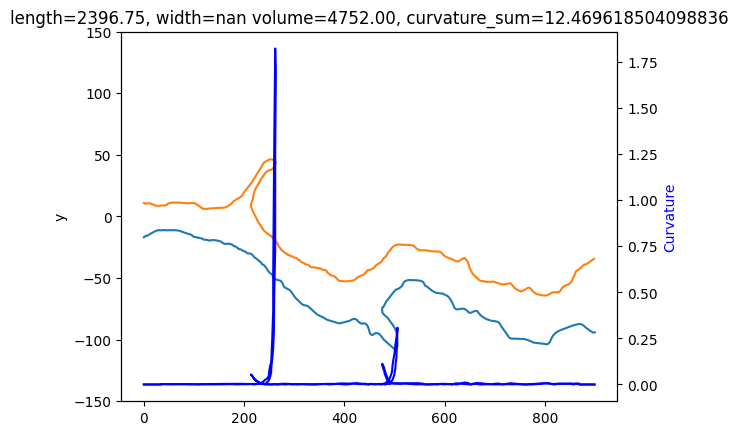

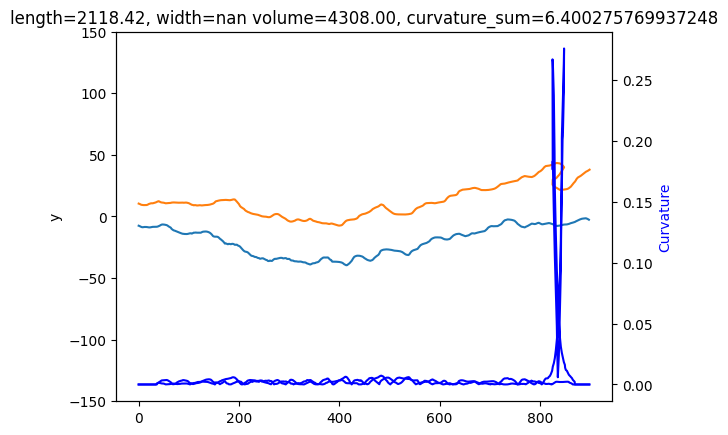

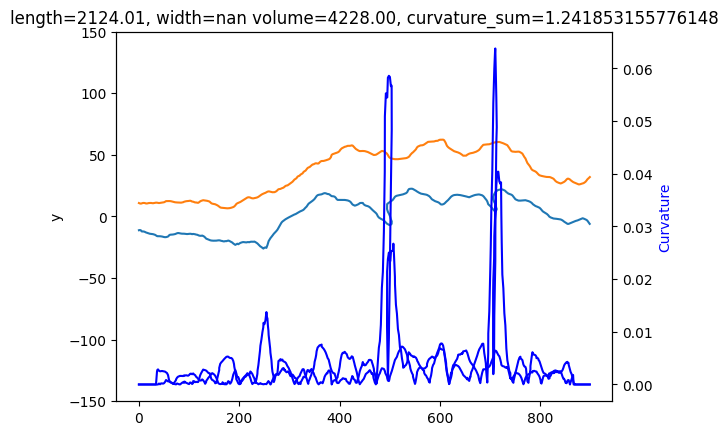

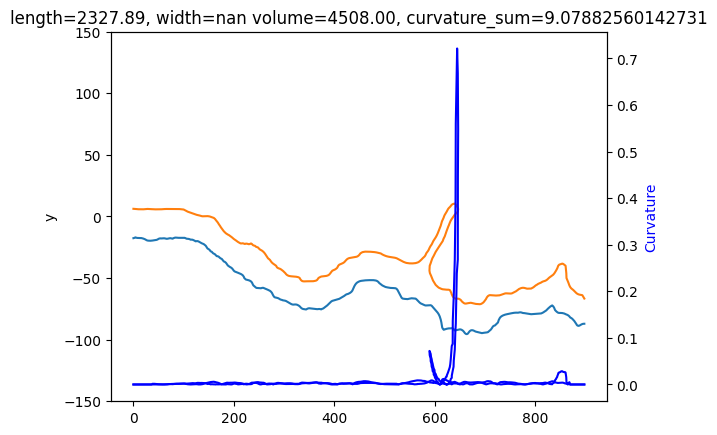

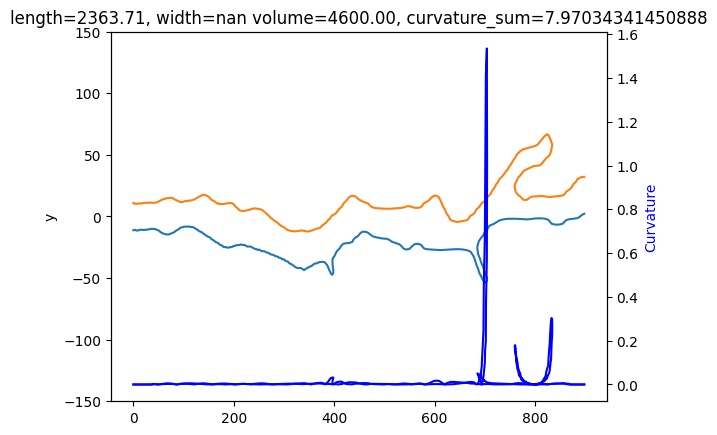

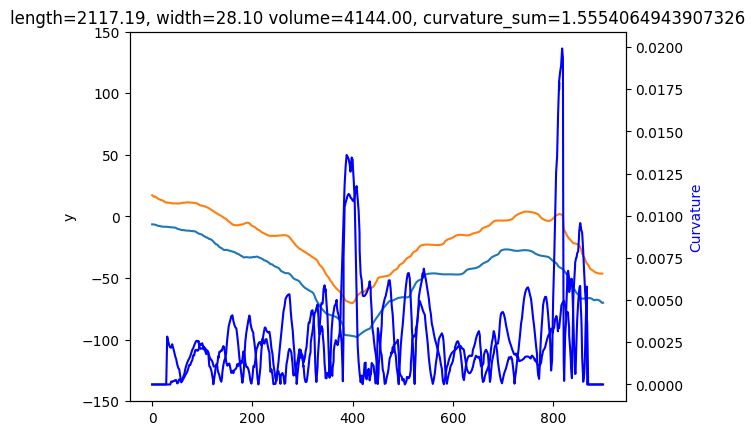

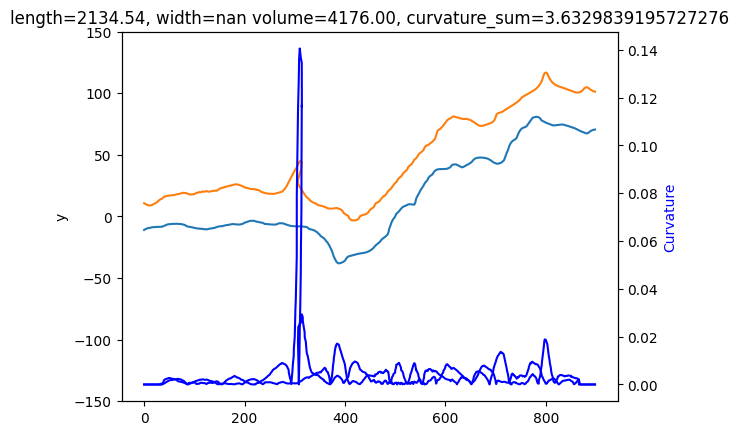

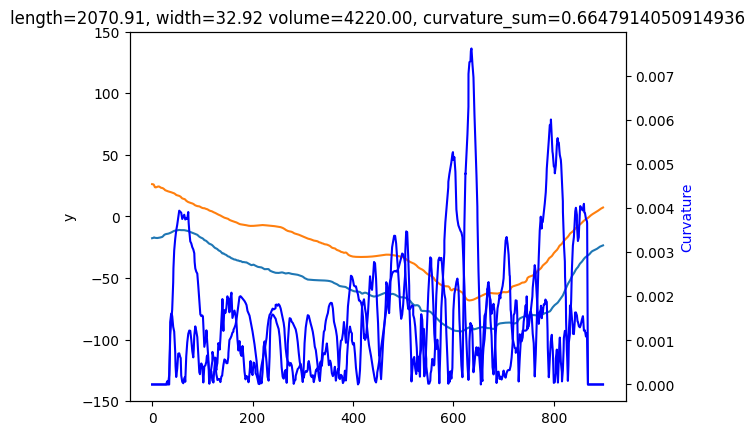

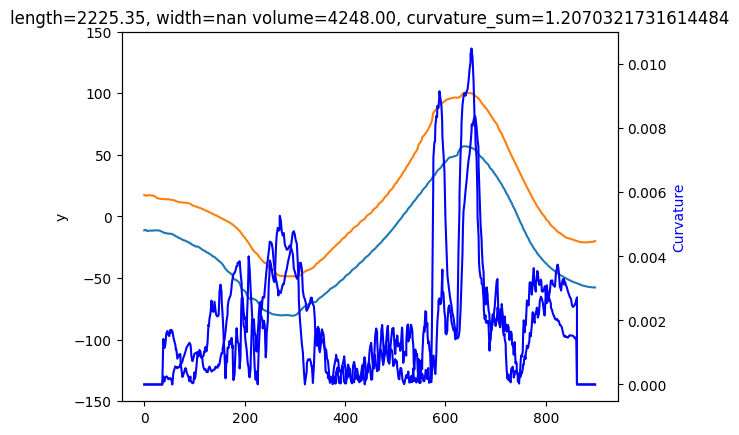

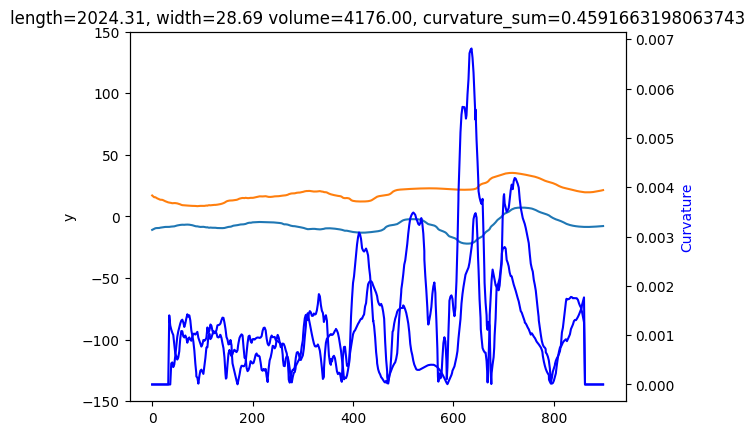

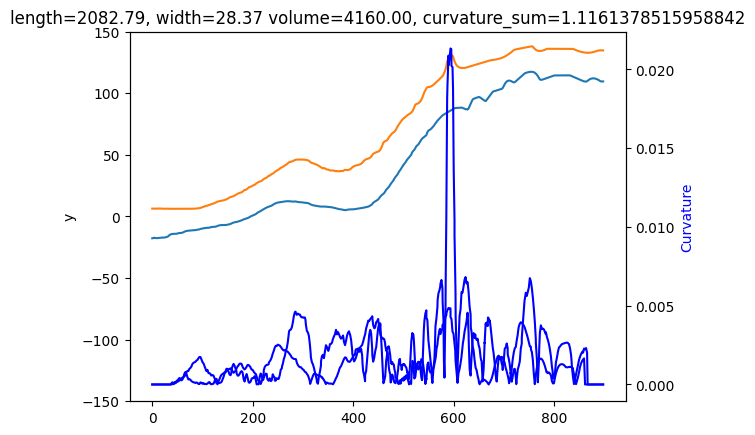

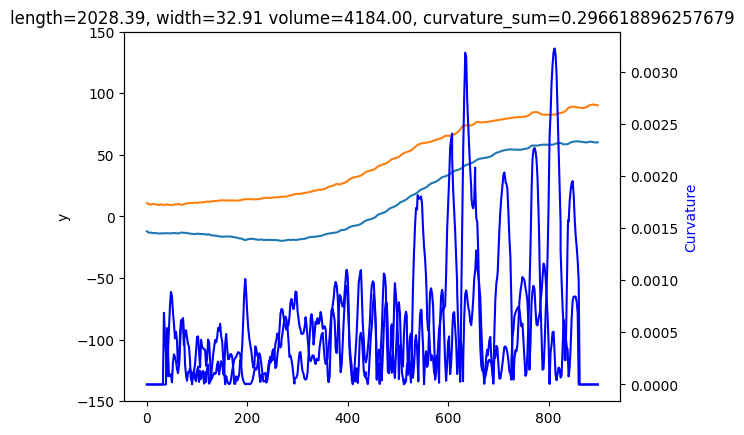

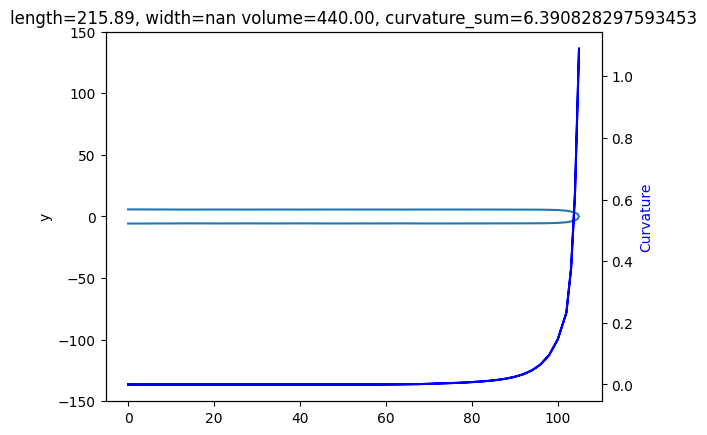

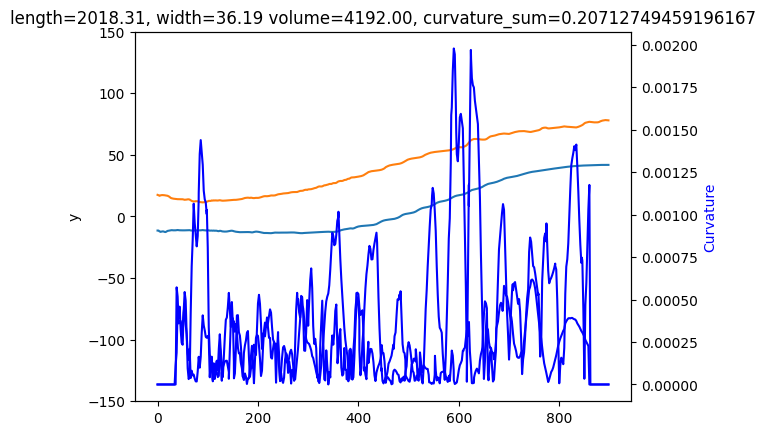

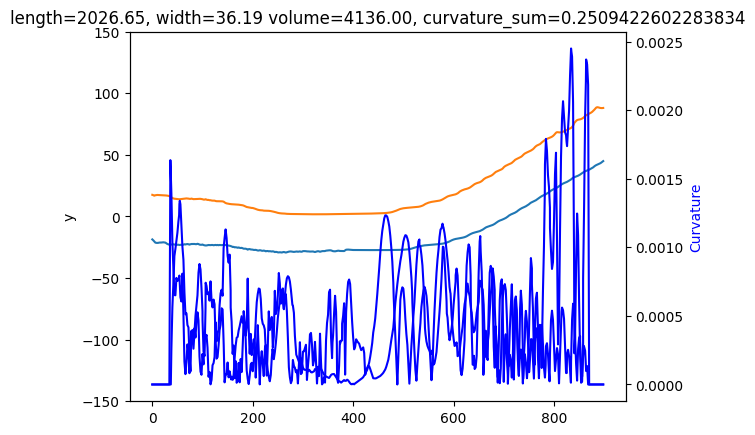

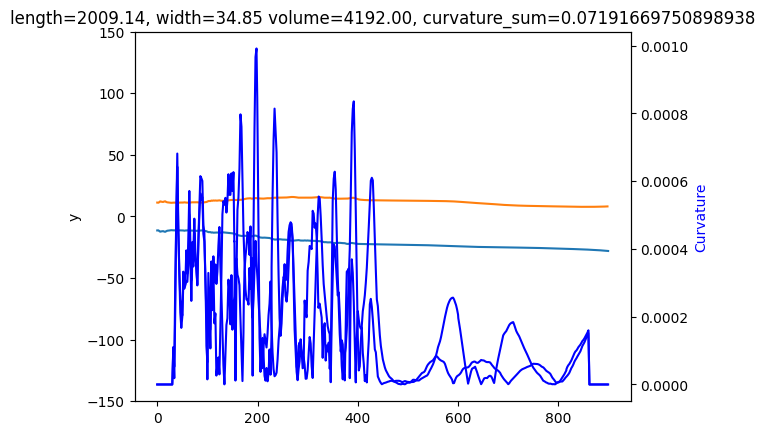

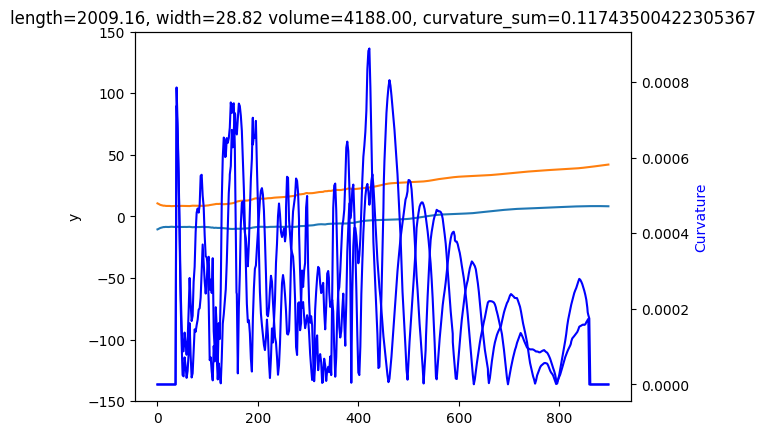

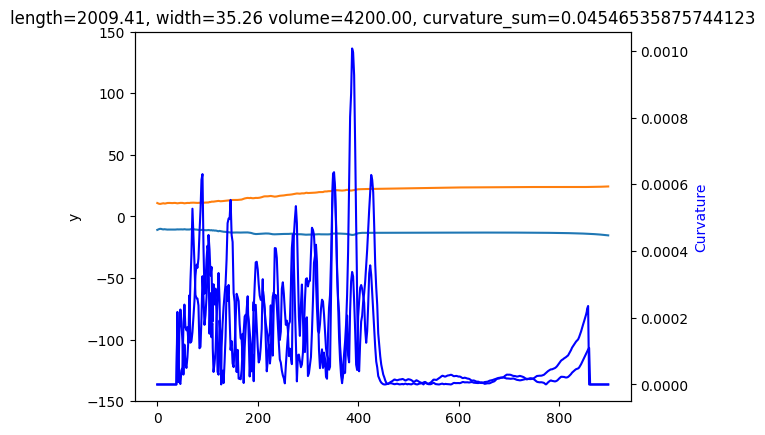

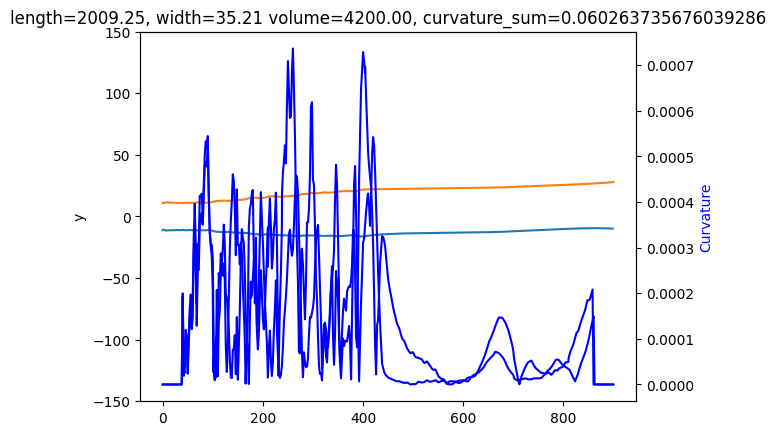

In [9]:
from src.measure.isolines import isolines_from_vtk
import numpy as np
import matplotlib.pyplot as plt
import src.measure.curvature as curvature

# random_indices = np.random.randint(0, len(df), 10)
all_indices = np.arange(len(df))
random_indices = all_indices

y_min, y_max = -150, 150 #df["structured_mesh_min_y"].min(), df["structured_mesh_max_y"].max()

for i in random_indices:
    # Select row by using the column "run" which contains the run number which has the same range as the index
    df_row = df.iloc[i]
    isolines = isolines_from_vtk(
        df_row["vtk_structured"],
        df_row["iso_value"],
    )
    # plt.figure()
    # curvatures = []
    # for isoline in isolines:
    #     isoline_curvature = curvature.calc_curvature(isoline, stride=20)
    #     curvatures.append(isoline_curvature)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax2.set_ylabel('Curvature', color='b')
    ax1.set_ylabel('y')
    ax1.set_ylim(y_min, y_max)

    # Cutoff the isolines at x=900, because afterwards there is some artifact: The crack is widening (without reason, for most simulations)
    cleaned_isolines = []
    for isoline in isolines:
        # remove all points with x > 900
        indices = np.where(isoline[:,0] < 900)[0]
        if len(indices) > 0:
            isoline = isoline[indices]
        cleaned_isolines.append(isoline)

    isolines = cleaned_isolines

    curvature_sum_sum = 0
    for isoline in isolines:
        if np.max(isoline[:, 0]) - np.min(isoline[:, 0]) < 100:
            continue
        isoline_curvature_local = curvature.calc_curvature(isoline, stride=20)
        curvature_sum = np.sum(isoline_curvature_local)
        curvature_sum_sum += curvature_sum
        # x = np.linspace(0, 1000, len(isoline_curvature_local))
        ax2.plot(isoline[:,0], isoline_curvature_local, color='b')
        # plt.plot(isoline[:,0], isoline_curvature_local)
        ax1.plot(isoline[:, 0], isoline[:, 1])
    ax1.set_title(f"length={df_row['length']:.2f}, width={df_row['width']:.2f} volume={df_row['volume']:.2f}, curvature_sum={curvature_sum}") #, curvature={isoline_curvature:.2f}")
    plt.show()

## Plot Volume